In [16]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate

from qiskit_algorithms import optimizers
from qiskit.primitives import Estimator

from scipy.optimize import minimize

# import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import *
# from qiskit_aer import Aer

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.mappers import JordanWignerMapper

# Para cargar lo necesario
import pickle

In [17]:
# ====================== Cargar datos desde el archivo ==================
# =======================================================================

# ================= Hamiltoniano =====================

with open("data/hamiltonian.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print("===================================================")
print(f"Hamiltoniano: \n{hamiltonian}")
print("===================================================\n")


# ================= Repulsión nuclear =====================

with open("data/nuclear_repulsion.pkl", "rb") as f:
    nuclear_repulsion = pickle.load(f)

print("===================================================")
print(f"Energía nuclear: {nuclear_repulsion}")
print("===================================================\n")

Hamiltoniano: 
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.80718366+0.j,  0.17374013+0.j, -0.23047453+0.j,  0.17374013+0.j,
 -0.23047453+0.j,  0.12148839+0.j,  0.16940471+0.j,  0.1665822 +0.j,
  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,  0.04509381+0.j,
  0.1665822 +0.j,  0.17510657+0.j,  0.12148839+0.j])

Energía nuclear: 0.7298996012689656



Iteración 1: Energía = -0.9664546278281114
Iteración 2: Energía = -0.943881767124228
Iteración 3: Energía = -0.9655920335269712
Iteración 4: Energía = -1.1278551487980066
Iteración 5: Energía = -1.107072227215202
Iteración 6: Energía = -1.1664883953714769
Iteración 7: Energía = -1.0162718734685006
Iteración 8: Energía = -1.1740240969526672
Iteración 9: Energía = -1.1764211979150825
Iteración 10: Energía = -1.0151196007660335
Iteración 11: Energía = -1.1834648316458058
Iteración 12: Energía = -1.1202754201793008
Iteración 13: Energía = -1.1182176334050853
Iteración 14: Energía = -1.2573569260563993
Iteración 15: Energía = -1.2028387215605345
Iteración 16: Energía = -1.3484205910114135
Iteración 17: Energía = -1.1942297849443222
Iteración 18: Energía = -1.3441142166030695
Iteración 19: Energía = -1.3344246424916293
Iteración 20: Energía = -1.2995040434703533
Iteración 21: Energía = -1.3751841907793056
Iteración 22: Energía = -1.224208211873741
Iteración 23: Energía = -1.383105720511152
I

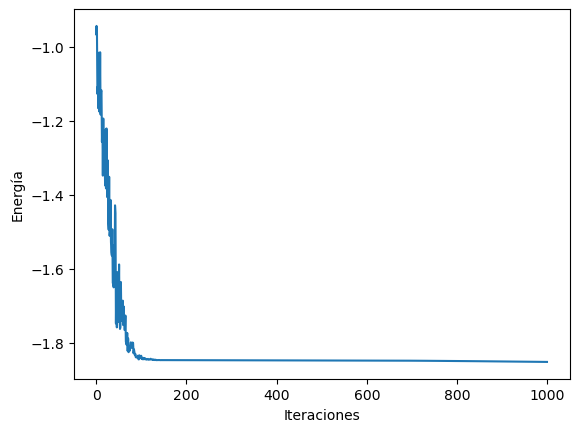

In [18]:
# Simulador local
simulator = Aer.get_backend('qasm_simulator')

# Ansatz de 4 qubits
theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=4,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],  # Keep rotation blocks
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [1, 2, 3]],  # Define entanglement pattern
    reps=2,
    insert_barriers=True,
)

num_params = ansatz.num_parameters

# Inicialización del parámetro
x0 = 2 * np.pi * np.random.random(num_params)

# Diccionario para almacenar la evolución del costo
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Función de coste
def cost_func(params, ansatz, hamiltonian, estimator):
    job = estimator.run([ansatz], [hamiltonian], [params])
    result = job.result()
    energy = result.values[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    print(f"Iteración {cost_history_dict['iters']}: Energía = {energy}")

    return energy

# Creamos el estimador para el simulador
backend=simulator
estimator = Estimator()

# Ejecutamos la optimización
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
)

# Resultado final
print("Parámetros óptimos:", res.x)
print("Energía mínima encontrada:", res.fun)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Energía")
plt.show()

In [19]:
# Energía total

energy = res.fun + nuclear_repulsion
print(f"Energía total: {energy}")

Energía total: -1.1220840944060024


c:\Users\juanl\miniconda3\envs\qiskit-tfm\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


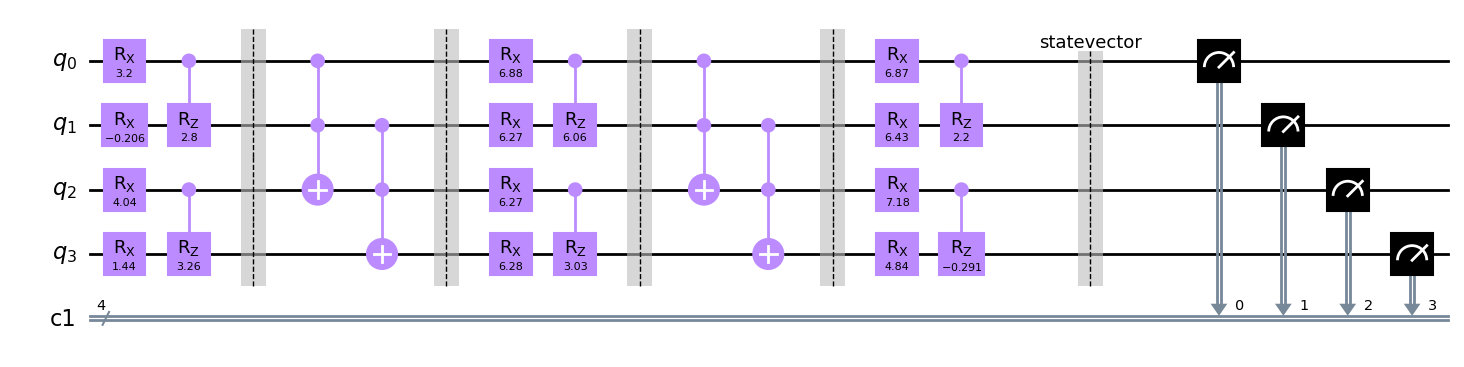

In [20]:
# Estado cuántico

qc_bound = ansatz.assign_parameters({list(ansatz.parameters)[i]: res.x[i] for i in range(len(res.x))}) # Asignamos los parámetros al circuito

c_reg = ClassicalRegister(ansatz.num_qubits) # Añadimos un bit clásico a qc_bound
qc_bound.add_register(c_reg)

qc_bound.save_statevector() # Guardamos el estado antes de la medida

qc_bound.measure(range(4),range(4)) # Medimos

qc_bound.decompose().draw("mpl") # Dibujamos

Statevector([ 7.23207402e-05+2.53580012e-05j,
             -1.21192657e-04+1.75300835e-03j,
             -7.86001788e-04+2.01819642e-03j,
              3.70927211e-03-6.62138024e-04j,
             -3.51623170e-03+2.36171769e-03j,
              1.71807248e-02+9.99729454e-01j,
             -3.47394499e-04+2.18895953e-03j,
             -1.73230756e-03+6.70271324e-05j,
             -8.64429973e-05+2.81385619e-04j,
              1.51246916e-04-6.19805707e-06j,
             -5.06829800e-03-2.16969303e-03j,
             -5.31041525e-03+9.43354673e-04j,
              4.17881506e-05+7.24492652e-05j,
              1.62409476e-03-3.28895778e-03j,
             -4.43678688e-03-2.93089434e-03j,
              1.02917401e-04+9.83142729e-03j],
            dims=(2, 2, 2, 2))


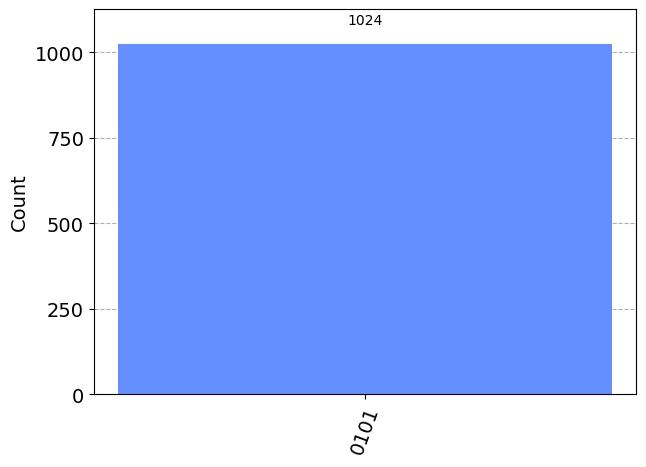

In [15]:
# Simulamos

sim = Aer.get_backend('qasm_simulator')
my_circuit = transpile(qc_bound, sim)
job = sim.run(my_circuit)
result = job.result()

sv = result.get_statevector()
print(sv)

counts = result.get_counts()
plot_histogram(counts)